In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten
import pandas as pd
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import timedelta
from keras.models import load_model

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Pengumpulan Data 

In [3]:
# Data Bank
file = 'stock_dataset/BBNI.JK.csv'
df = pd.read_csv(file, parse_dates = True,index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,6050.0,6125.0,6050.0,6100.0,5013.987793,11700700.0
2015-01-05,6075.0,6075.0,6000.0,6025.0,4952.338867,13824800.0
2015-01-06,6000.0,6050.0,5950.0,6025.0,4952.338867,23801400.0
2015-01-07,6000.0,6100.0,5975.0,6075.0,4993.437500,19387800.0
2015-01-08,6100.0,6125.0,6025.0,6075.0,4993.437500,16755600.0
...,...,...,...,...,...,...
2021-12-15,6850.0,6975.0,6825.0,6875.0,6875.000000,19528200.0
2021-12-16,6925.0,6950.0,6750.0,6750.0,6750.000000,22156100.0
2021-12-17,6750.0,6850.0,6725.0,6750.0,6750.000000,23308800.0


In [4]:
# Data Kurs Rupiah
file = 'stock_dataset/Kurs_Transaksi_USD.csv'
df1 = pd.read_csv(file, parse_dates = True,index_col=0)
df1

,Nilai,Kurs Jual,Kurs Beli
Date,,,
2015-01-02,1,12536.00,12412.00
2015-01-05,1,12652.00,12526.00
2015-01-06,1,12721.00,12595.00
2015-01-07,1,12796.00,12668.00
2015-01-08,1,12795.00,12667.00
...,...,...,...
2021-12-15,1,14419.74,14276.26
2021-12-16,1,14408.69,14265.32
2021-12-17,1,14414.72,14271.29


# Preprocessing Data

In [5]:
# menggabungkan data kurs dan data harga saham 
data = pd.merge_asof(df, df1, on='Date')
data = data.rename(columns = {'Adj Close' : 'adj_close', 'Kurs Jual' : 'kurs_jual', 'Kurs Beli' : 'kurs_beli'})
dataset = data.set_index('Date')
dataset

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2015-01-02,6050.0,6125.0,6050.0,6100.0,5013.987793,11700700.0,1,12536.00,12412.00
2015-01-05,6075.0,6075.0,6000.0,6025.0,4952.338867,13824800.0,1,12652.00,12526.00
2015-01-06,6000.0,6050.0,5950.0,6025.0,4952.338867,23801400.0,1,12721.00,12595.00
2015-01-07,6000.0,6100.0,5975.0,6075.0,4993.437500,19387800.0,1,12796.00,12668.00
2015-01-08,6100.0,6125.0,6025.0,6075.0,4993.437500,16755600.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...
2021-12-15,6850.0,6975.0,6825.0,6875.0,6875.000000,19528200.0,1,14419.74,14276.26
2021-12-16,6925.0,6950.0,6750.0,6750.0,6750.000000,22156100.0,1,14408.69,14265.32
2021-12-17,6750.0,6850.0,6725.0,6750.0,6750.000000,23308800.0,1,14414.72,14271.29


In [6]:
# Periksa nilai yang hilang
dataset.isnull().sum()

Open         1
High         1
Low          1
Close        1
adj_close    1
Volume       1
Nilai        0
kurs_jual    0
kurs_beli    0
dtype: int64

In [7]:
nul_data = pd.isnull(dataset['Close']) 
dataset[nul_data]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN,1,14342.0,14200.0


In [8]:
# Ganti nilai yang hilang dengan interpolasi
dataset = dataset.fillna(dataset.interpolate(method='linear'))
dataset.to_csv("stock_dataset/data_cleaning_bn.csv", index=True)
dataset.loc[["2019-06-19"]]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,8750.0,8875.0,8587.5,8762.5,8440.414551,29277100.0,1,14342.0,14200.0


In [9]:
dataset = dataset.reset_index()
dataset

,Date,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
0,2015-01-02,6050.0,6125.0,6050.0,6100.0,5013.987793,11700700.0,1,12536.00,12412.00
1,2015-01-05,6075.0,6075.0,6000.0,6025.0,4952.338867,13824800.0,1,12652.00,12526.00
2,2015-01-06,6000.0,6050.0,5950.0,6025.0,4952.338867,23801400.0,1,12721.00,12595.00
3,2015-01-07,6000.0,6100.0,5975.0,6075.0,4993.437500,19387800.0,1,12796.00,12668.00
4,2015-01-08,6100.0,6125.0,6025.0,6075.0,4993.437500,16755600.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...,...
1741,2021-12-15,6850.0,6975.0,6825.0,6875.0,6875.000000,19528200.0,1,14419.74,14276.26
1742,2021-12-16,6925.0,6950.0,6750.0,6750.0,6750.000000,22156100.0,1,14408.69,14265.32
1743,2021-12-17,6750.0,6850.0,6725.0,6750.0,6750.000000,23308800.0,1,14414.72,14271.29
1744,2021-12-20,6750.0,6775.0,6650.0,6725.0,6725.000000,21182400.0,1,14414.72,14271.29


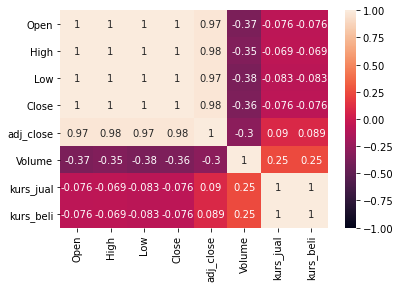

In [10]:
# Korelasi Data
dataset.drop(['Nilai'], axis=1, inplace=True)
matrix = dataset.corr(method='pearson')
ax = sns.heatmap(matrix, vmax=1, vmin=-1, annot=True)
ax.figure.savefig('M:/Metopen/save/korelasi_bn.jpg')

In [11]:
# pemilihan fitur
df = read_csv('stock_dataset/data_cleaning_bn.csv', header=0, index_col=0)
df.drop(['Volume', 'Nilai', 'kurs_jual', 'kurs_beli'], axis=1, inplace=True)
df

,Open,High,Low,Close,adj_close
Date,,,,,
2015-01-02,6050.0,6125.0,6050.0,6100.0,5013.987793
2015-01-05,6075.0,6075.0,6000.0,6025.0,4952.338867
2015-01-06,6000.0,6050.0,5950.0,6025.0,4952.338867
2015-01-07,6000.0,6100.0,5975.0,6075.0,4993.437500
2015-01-08,6100.0,6125.0,6025.0,6075.0,4993.437500
...,...,...,...,...,...
2021-12-15,6850.0,6975.0,6825.0,6875.0,6875.000000
2021-12-16,6925.0,6950.0,6750.0,6750.0,6750.000000
2021-12-17,6750.0,6850.0,6725.0,6750.0,6750.000000


In [12]:
# pindah kolom baris close ke baris pertama
last_col = df.pop('Close')
type(last_col)
pd.core.series.Series
df.insert(loc=0, column = 'Close', value = last_col)
df

,Close,Open,High,Low,adj_close
Date,,,,,
2015-01-02,6100.0,6050.0,6125.0,6050.0,5013.987793
2015-01-05,6025.0,6075.0,6075.0,6000.0,4952.338867
2015-01-06,6025.0,6000.0,6050.0,5950.0,4952.338867
2015-01-07,6075.0,6000.0,6100.0,5975.0,4993.437500
2015-01-08,6075.0,6100.0,6125.0,6025.0,4993.437500
...,...,...,...,...,...
2021-12-15,6875.0,6850.0,6975.0,6825.0,6875.000000
2021-12-16,6750.0,6925.0,6950.0,6750.0,6750.000000
2021-12-17,6750.0,6750.0,6850.0,6725.0,6750.000000


In [13]:
df.describe()

,Close,Open,High,Low,adj_close
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,6566.000859,6570.174685,6650.323597,6483.924685,6076.566245
std,1543.479595,1538.893627,1546.634630,1533.412031,1528.586314
min,3160.000000,3160.000000,3410.000000,2970.000000,3135.911377
25%,5250.000000,5250.000000,5325.000000,5181.250000,4700.951660
50%,6500.000000,6500.000000,6600.000000,6425.000000,5954.262207
75%,7625.000000,7625.000000,7700.000000,7525.000000,7272.482422
max,10175.000000,10175.000000,10250.000000,9900.000000,9305.716797


In [14]:
# pastikan semua data bertipe float
values = df.values
values = values.astype('float32')
values

# normalisasi fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.41910192, 0.41197434, 0.3969298 , 0.44444442, 0.304398  ],
       [0.40841058, 0.41553816, 0.3896199 , 0.43722945, 0.29440594],
       [0.40841058, 0.40484676, 0.38596487, 0.43001443, 0.29440594],
       ...,
       [0.5117605 , 0.5117605 , 0.50292397, 0.54184705, 0.58577025],
       [0.5081967 , 0.5117605 , 0.49195904, 0.5310245 , 0.5817183 ],
       [0.50463295, 0.5081967 , 0.495614  , 0.534632  , 0.5776663 ]],
      dtype=float32)

In [15]:
# konversi series ke supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
# frame sebagai supervised learning
ref = series_to_supervised(scaled, 1, 1)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.419102,0.411974,0.396930,0.444444,0.304398,0.408411,0.415538,0.389620,0.437229,0.294406
2,0.408411,0.415538,0.389620,0.437229,0.294406,0.408411,0.404847,0.385965,0.430014,0.294406
3,0.408411,0.404847,0.385965,0.430014,0.294406,0.415538,0.404847,0.393275,0.433622,0.301067
4,0.415538,0.404847,0.393275,0.433622,0.301067,0.415538,0.419102,0.396930,0.440837,0.301067
5,0.415538,0.419102,0.396930,0.440837,0.301067,0.426230,0.415538,0.415205,0.448052,0.311059
...,...,...,...,...,...,...,...,...,...,...
1741,0.529580,0.526016,0.510234,0.549062,0.606030,0.529580,0.526016,0.521199,0.556277,0.606030
1742,0.529580,0.526016,0.521199,0.556277,0.606030,0.511760,0.536707,0.517544,0.545455,0.585770
1743,0.511760,0.536707,0.517544,0.545455,0.585770,0.511760,0.511760,0.502924,0.541847,0.585770
1744,0.511760,0.511760,0.502924,0.541847,0.585770,0.508197,0.511760,0.491959,0.531025,0.581718


In [17]:
# drop kolom yang tidak ingin diprediksi
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref.to_csv("stock_dataset/normalisasi_bn.csv", index=False)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.419102,0.411974,0.396930,0.444444,0.304398,0.408411
2,0.408411,0.415538,0.389620,0.437229,0.294406,0.408411
3,0.408411,0.404847,0.385965,0.430014,0.294406,0.415538
4,0.415538,0.404847,0.393275,0.433622,0.301067,0.415538
5,0.415538,0.419102,0.396930,0.440837,0.301067,0.426230
...,...,...,...,...,...,...
1741,0.529580,0.526016,0.510234,0.549062,0.606030,0.529580
1742,0.529580,0.526016,0.521199,0.556277,0.606030,0.511760
1743,0.511760,0.536707,0.517544,0.545455,0.585770,0.511760
1744,0.511760,0.511760,0.502924,0.541847,0.585770,0.508197


In [18]:
# pembagian data pelatihan dan pengujian
values = ref.values

train_size = 0.8
valid_size=0.1

train_index = int(len(values)*train_size)

train = values[0:train_index]
rem = values[train_index:]

valid_index = int(len(values)*valid_size)

valid = values[train_index:train_index+valid_index]
test = values[train_index+valid_index:]

print(train.shape, valid.shape, test.shape)

(1396, 6) (174, 6) (175, 6)


In [19]:
# membuat dataset
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]

# reshape masukan menjadi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(1396, 1, 5) (1396,) (174, 1, 5) (174,) (175, 1, 5) (175,)


# Perancangan dan Pelatihan Model biLSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 254)           135128    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 254)               0         
                                                                 
 dense (Dense)               (None, 115)               29325     
                                                                 
 dropout (Dropout)           (None, 115)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 116       
                                                                 
Total params: 164,569
Trainable params: 164,569
Non-trainable params: 0
__________________________________________________

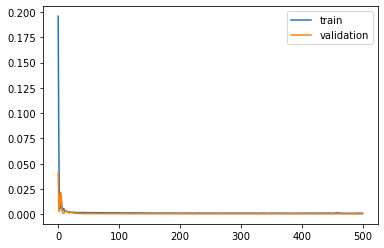

In [20]:
# membuat rancangan model
model = Sequential()
# bidirectinal layer
model.add(Bidirectional(LSTM(127, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
# fully connected layer
model.add(Flatten())
model.add(Dense(115, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()
# pelatihan model
history = model.fit(train_X, train_y, batch_size= 350, epochs= 500, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.savefig('M:/Metopen/save/loss_bn.jpg', format='jpg', dpi=1000)
pyplot.legend()
pyplot.show()

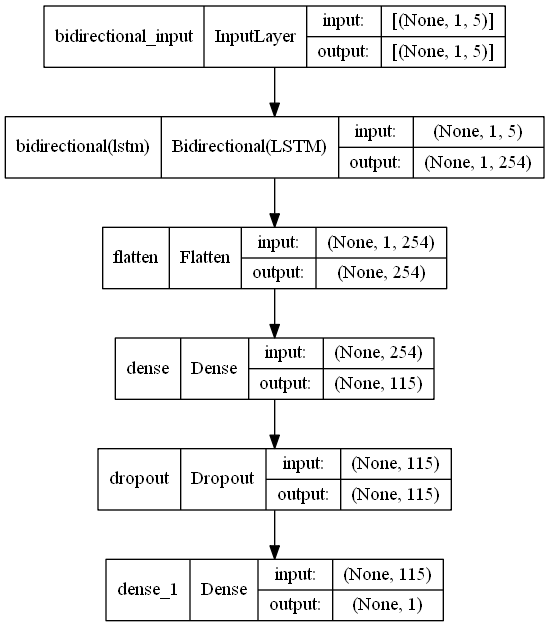

In [21]:
# plot model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='M:/Metopen/save/model_bn.png', show_shapes=True, show_layer_names=True)

# Evaluasi Model

In [22]:
# evaluasi model dengan data pengujian
evaluasi = model.evaluate(train_X, train_y)
print("train loss:", "train metrics:", evaluasi)

44/44 [==============================] - 0s 2ms/step - loss: 3.9750e-04 - root_mean_squared_error: 0.0199
train loss: train metrics: [0.0003974991850554943, 0.019937381148338318]


In [23]:
# evaluasi model dengan data pengujian
evaluasi = model.evaluate(test_X, test_y)
print("test loss:", "test metrics:", evaluasi)

6/6 [==============================] - 0s 3ms/step - loss: 2.8909e-04 - root_mean_squared_error: 0.0170
test loss: test metrics: [0.00028908823151141405, 0.017002595588564873]


In [24]:
model.save('M:/Metopen/save/model_bni.h5')
model.save_weights('M:/Metopen/save/model_weights_bni.h5')

# Prediksi Data

In [25]:
# load model
model = load_model('M:/Metopen/save/model_bni.h5')
model.load_weights('M:/Metopen/save/model_weights_bni.h5')

# load data bank BRI baru
df = read_csv('stock_dataset/BBNI.JK_revisi.csv', parse_dates = True, index_col=0)
dataset = df.reset_index()

In [26]:
data = dataset.set_index('Date')
last_col = data.pop('Close')
type(last_col)
pd.core.series.Series
data.insert(loc=0, column = 'Close', value = last_col)
data

,Close,Open,High,Low,Adj Close
Date,,,,,
2021-12-22,6625,6750,6775,6600,6504.973145
2021-12-23,6650,6625,6675,6625,6529.520508
2021-12-24,6725,6650,6725,6575,6603.161621
2021-12-27,6750,6725,6750,6675,6627.708496
2021-12-28,6700,6750,6775,6700,6578.614258
...,...,...,...,...,...
2022-08-24,8300,8300,8400,8250,8300.000000
2022-08-25,8275,8350,8375,8250,8275.000000
2022-08-26,8300,8325,8400,8300,8300.000000


In [27]:
# normalisasi data uji baru
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# konversi data uji baru
ref = series_to_supervised(scaled, 1, 1)
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.000000,0.042017,0.031008,0.008621,0.000000,0.008403
2,0.008403,0.000000,0.000000,0.017241,0.007931,0.033613
3,0.033613,0.008403,0.015504,0.000000,0.031725,0.042017
4,0.042017,0.033613,0.023256,0.034483,0.039656,0.025210
5,0.025210,0.042017,0.031008,0.043103,0.023793,0.033613
...,...,...,...,...,...,...
160,0.563025,0.563025,0.534884,0.586207,0.579971,0.563025
161,0.563025,0.563025,0.534884,0.577586,0.579971,0.554622
162,0.554622,0.579832,0.527132,0.577586,0.571894,0.563025
163,0.563025,0.571429,0.534884,0.594828,0.579971,0.529412


In [28]:
# membuat dataset 
values = ref.values
new_test_X, new_test_y = values[:, :-1], values[:, -1]
new_test_X = new_test_X.reshape((new_test_X.shape[0], 1, new_test_X.shape[1]))
print(new_test_X.shape, new_test_y.shape)

(164, 1, 5) (164,)


In [29]:
# membuat prediksi dengan data yang baru 
predict = model.predict(new_test_X)
new_test_X = new_test_X.reshape((new_test_X.shape[0], new_test_X.shape[2]))
# denormalisasi untuk data prediksi
inv_predict = concatenate((predict, new_test_X[:, 1:]), axis=1)
inv_predict = scaler.inverse_transform(inv_predict)
inv_predict = inv_predict[:, 0]
# denormalisasi untuk data aktual
new_test_y = new_test_y.reshape((len(new_test_y), 1))
inv_actual = concatenate((new_test_y, new_test_X[:, 1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]

In [30]:
# hasil prediksi sebelum denormalisasi
predict

array([[0.01509492],
       [0.01407597],
       [0.02795007],
       [0.04112526],
       [0.03553999],
       [0.03657982],
       [0.0429487 ],
       [0.04191554],
       [0.12012069],
       [0.1113348 ],
       [0.10603422],
       [0.14310324],
       [0.1508248 ],
       [0.13915023],
       [0.14190511],
       [0.13721004],
       [0.1547859 ],
       [0.18189088],
       [0.1538185 ],
       [0.14938867],
       [0.16386734],
       [0.17545517],
       [0.15626921],
       [0.08235072],
       [0.14907463],
       [0.18928017],
       [0.26966867],
       [0.24717313],
       [0.24588989],
       [0.22313051],
       [0.22785026],
       [0.24947801],
       [0.29052114],
       [0.30774078],
       [0.34569243],
       [0.35218707],
       [0.34832016],
       [0.41728064],
       [0.4353742 ],
       [0.41534245],
       [0.43493924],
       [0.42456654],
       [0.37530825],
       [0.41887572],
       [0.3999662 ],
       [0.44000313],
       [0.4479642 ],
       [0.386

In [31]:
# hasil prediksi pada setiap langkah waktu
inv_test_X= scaler.inverse_transform(new_test_X)

for i in range(len(inv_test_X)):
    print("X=%s, Predicted= %s" % (inv_test_X[i], inv_predict[i]))

X=[6625.       6750.       6775.       6600.       6504.973145], Predicted= 6669.9073733296245
X=[6650.       6625.       6675.       6625.       6529.520508], Predicted= 6666.876000491902
X=[6725.       6650.       6725.       6575.       6603.161621], Predicted= 6708.151460625231
X=[6750.       6725.       6750.       6675.       6627.708496], Predicted= 6747.347649373114
X=[6700.       6750.       6775.       6700.       6578.614258], Predicted= 6730.731465574354
X=[6725.       6700.       6750.       6675.       6603.161621], Predicted= 6733.82496824488
X=[6750.       6725.       6775.       6675.       6627.708496], Predicted= 6752.772383950651
X=[6725.       6750.       6800.       6700.       6603.161621], Predicted= 6749.698741547763
X=[7025.       6800.       7050.       6775.       6897.726563], Predicted= 6982.35905058682
X=[6950.       7025.       7050.       6850.       6824.084961], Predicted= 6956.221032142639
X=[6950.       6950.       7000.       6825.       6824.08496

In [32]:
# menghitung nilai RMSE dan Mape pada hasil prediksi
rmse = sqrt(mean_squared_error(inv_predict, inv_actual))
print('Test RMSE: %.2f' % rmse)
mape = np.mean(np.abs((inv_actual - inv_predict)/inv_actual))*100
print(f'Test MAPE: {np.round(mape, 2)} %')

Test RMSE: 161.04
Test MAPE: 1.43 %


In [33]:
# insert nilai tanggal, aktual, prediksi
test = dataset.drop(dataset.index[0])
test.insert(1, "Prediction", inv_predict.ravel(), True)
#test.insert(1, "Difference", test["Prediction"] - test["Actual"], True)

In [34]:
# perbandingan hasil pengujian dan prediksi
test = pd.DataFrame(test, columns = ["Date", "Close", "Prediction"])
test["RMSE"] = test.apply(lambda x: mean_squared_error(test.loc[:x.name, 'Close'].tolist(), test.loc[:x.name, 'Prediction'].tolist(), squared=False), axis = 1)
test["MAPE"] = test.apply(lambda x: np.mean(np.abs((test.loc[:x.name, 'Close'].tolist() - test.loc[:x.name, 'Prediction'])/test.loc[:x.name, 'Close'].tolist()))*100, axis=1)
test.to_csv("M:/Metopen/save/hasil_prediksi_bn.csv", index=False)
print(test)

          Date  Close   Prediction        RMSE      MAPE
1   2021-12-23   6650  6669.907373   19.907373  0.299359
2   2021-12-24   6725  6666.876000   43.443658  0.581828
3   2021-12-27   6750  6708.151461   42.918539  0.594545
4   2021-12-28   6700  6747.347649   44.067570  0.622579
5   2021-12-29   6725  6730.731466   39.498488  0.515108
..         ...    ...          ...         ...       ...
160 2022-08-24   8300  8283.537157  161.653444  1.434907
161 2022-08-25   8275  8278.223117  161.150833  1.426237
162 2022-08-26   8300  8257.894005  160.686741  1.420564
163 2022-08-29   8200  8288.409483  160.342679  1.418464
164 2022-08-30   8425  8175.577097  161.035238  1.427866

[164 rows x 5 columns]


# Visualisasi Data

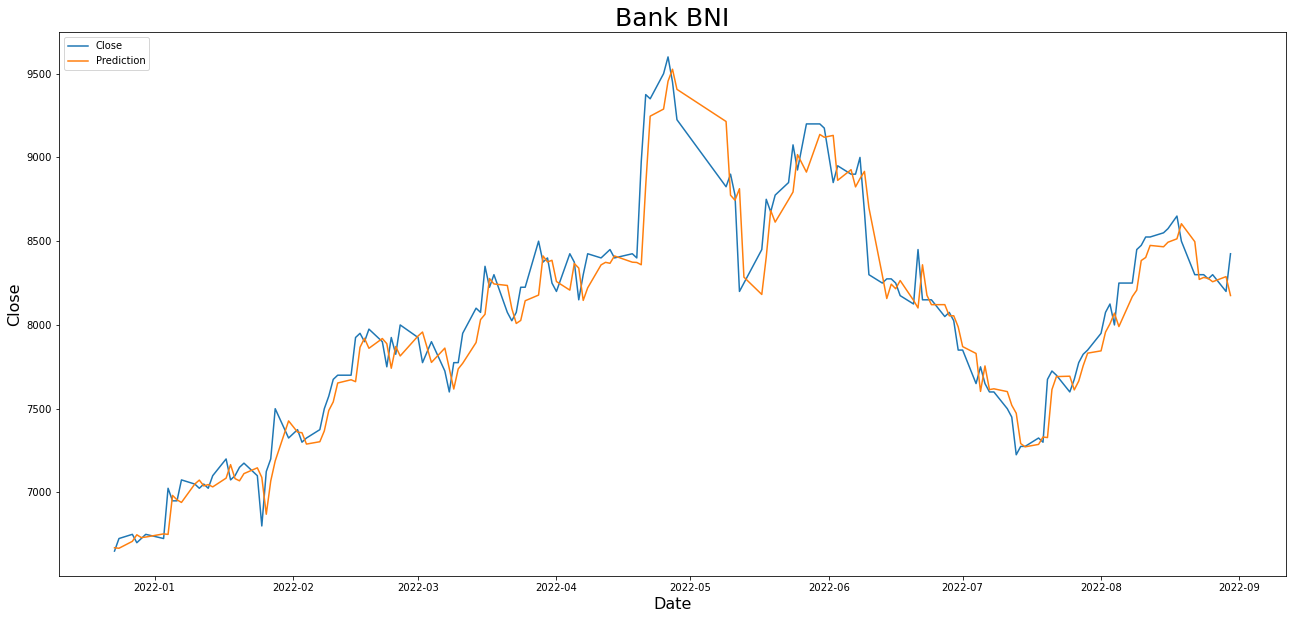

In [35]:
# visualisasi data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = test["Date"]
yt = test[["Close", "Prediction"]]
plt.title("Bank BNI", fontsize= 25)
plt.plot(xt, yt["Close"])
plt.ylabel("Close", fontsize= 16)
plt.xlabel("Date", fontsize= 16)
plt.plot(xt, yt["Prediction"])
plt.legend(["Close","Prediction"], loc="upper left")
plt.savefig('M:/Metopen/save/hasil_prediksi_bn.jpg', format='jpg', dpi=1000)

#plt.grid()
plt.show()